<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# 1.	Dataset Selection and Preprocessing
# Install required libraries
!pip install -q datasets spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
# Imports
import re
import pandas as pd
from datasets import load_dataset
import spacy

#Load Dataset
# Will use the IMDb movie reviews dataset
dataset = load_dataset("imdb")

# Convert to pandas DataFrames
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)
train_df.head()

# Handle Missing Values
# Drop any missing or empty text entries
train_df.dropna(subset=["text"], inplace=True)
test_df.dropna(subset=["text"], inplace=True)

train_df = train_df[train_df["text"].str.strip() != ""]
test_df = test_df[test_df["text"].str.strip() != ""]

print("After cleaning:")
print(train_df.shape, test_df.shape)

# Text Cleaning Function
# Initialize spaCy English model (for optional lemmatization)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

REPLACE_BY_SPACE_RE = re.compile(r"[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile(r"[^0-9a-z #+_']")

def clean_text(text, lemmatize=False):
    """Cleans raw text and optionally lemmatizes it."""
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(" ", text)
    text = BAD_SYMBOLS_RE.sub("", text)
    text = re.sub(r"\s+", " ", text).strip()
    if lemmatize:
        doc = nlp(text)
        text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return text

# Apply cleaning
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

# Normalize / Scale Features
# Not needed for text data here

# Split Data for Validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean_text"],
    train_df["label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Test samples:", len(test_df))


Training data shape: (25000, 2)
Testing data shape: (25000, 2)
After cleaning:
(25000, 2) (25000, 2)
Train samples: 20000
Validation samples: 5000
Test samples: 25000


BoW features shape: (20000, 20000)
TF-IDF features shape: (20000, 20000)
Word2Vec document matrix: (20000, 100)


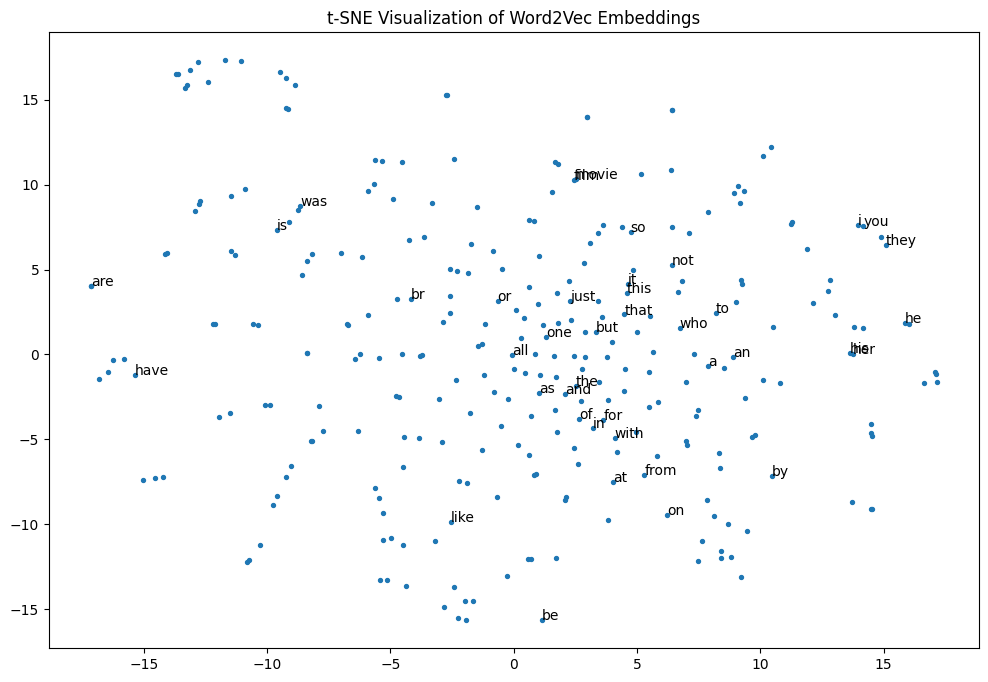

In [9]:
# 2. Feature Engineering
# Install required libraries
!pip install -q scikit-learn gensim matplotlib seaborn

# Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Bag of Words
bow_vectorizer = CountVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(test_df["clean_text"])

print("BoW features shape:", X_train_bow.shape)

# TF-IDF Vector
tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_text"])

print("TF-IDF features shape:", X_train_tfidf.shape)

# Word2Vec Embeddings
# Prepare tokenized sentences for Word2Vec
sentences = [text.split() for text in X_train]

# Train Word2Vec model on training corpus
word2vec_model = Word2Vec(
    sentences,
    vector_size=100,  # Dimension
    window=5,
    min_count=5,
    workers=4,
    epochs=10
)

# Function to convert text to average Word2Vec vector
def document_vector(doc):
    words = doc.split()
    valid_words = [w for w in words if w in word2vec_model.wv]
    if not valid_words:
        return np.zeros(100)
    return np.mean(word2vec_model.wv[valid_words], axis=0)

X_train_w2v = np.vstack([document_vector(d) for d in X_train])
X_val_w2v = np.vstack([document_vector(d) for d in X_val])
X_test_w2v = np.vstack([document_vector(d) for d in test_df["clean_text"]])

print("Word2Vec document matrix:", X_train_w2v.shape)

# Visualizing Word Embeddings
# Take a sample of words from the vocabulary
sample_words = list(word2vec_model.wv.index_to_key)[:300]
word_vectors = np.array([word2vec_model.wv[w] for w in sample_words])

# Dimensionality reduction for visualization
pca = PCA(n_components=50)
word_vecs_pca = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
word_vecs_tsne = tsne.fit_transform(word_vecs_pca)

# Plot t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(word_vecs_tsne[:, 0], word_vecs_tsne[:, 1], s=8)
for i, word in enumerate(sample_words[:40]):  # annotate a few
    plt.annotate(word, (word_vecs_tsne[i, 0], word_vecs_tsne[i, 1]))
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()


In [ ]:
# 3. Text Classification Using Traditional Models
!pip install -q scikit-learn matplotlib seaborn joblib

# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Helper function: evaluate model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Train model, predict, and return evaluation metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Compute probabilities or decision function for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_val)[:, 1]
    else:
        y_score = model.decision_function(X_val)

    metrics = {
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "f1_score": f1_score(y_val, y_pred),
        "roc_auc": roc_auc_score(y_val, y_score)
    }
    return metrics, y_pred, y_score


# Logistic Regression on TF-IDF
lr = LogisticRegression(max_iter=1000)
param_grid_lr = {"C": [0.01, 0.1, 1, 10]}

grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring="f1", n_jobs=-1, verbose=1)
grid_lr.fit(X_train_tfidf, y_train)

best_lr = grid_lr.best_estimator_
lr_metrics, lr_preds, lr_probs = evaluate_model(best_lr, X_train_tfidf, y_train, X_val_tfidf, y_val)

print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Validation Metrics", lr_metrics)


# Support Vector Machine on TF-IDF
svm = SVC(kernel="linear", probability=True)
param_grid_svm = {"C": [0.01, 0.1, 1, 10]}

grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring="f1", n_jobs=-1, verbose=1)
grid_svm.fit(X_train_tfidf, y_train)

best_svm = grid_svm.best_estimator_
svm_metrics, svm_preds, svm_probs = evaluate_model(best_svm, X_train_tfidf, y_train, X_val_tfidf, y_val)

print("Best SVM Params:", grid_svm.best_params_)
print("Validation Metrics (TF-IDF):", svm_metrics)


# Logistic Regression on Word2Vec (Dense Embeddings)
lr_w2v = LogisticRegression(max_iter=1000)
param_grid_lr_w2v = {"C": [0.01, 0.1, 1, 10]}

grid_lr_w2v = GridSearchCV(lr_w2v, param_grid_lr_w2v, cv=3, scoring="f1", n_jobs=-1, verbose=1)
grid_lr_w2v.fit(X_train_w2v, y_train)

best_lr_w2v = grid_lr_w2v.best_estimator_
lr_w2v_metrics, lr_w2v_preds, lr_w2v_probs = evaluate_model(best_lr_w2v, X_train_w2v, y_train, X_val_w2v, y_val)

print("Best Logistic Regression Params (Word2Vec):", grid_lr_w2v.best_params_)
print("Validation Metrics (Word2Vec):", lr_w2v_metrics)


# Visualization — Confusion Matrix and ROC Curve
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


# Confusion Matrix and ROC for best Logistic Regression
plot_confusion(y_val, lr_preds, "Logistic Regression (TF-IDF) Confusion Matrix")
plot_roc(y_val, lr_probs, "Logistic Regression (TF-IDF) ROC Curve")

# Save Best Models
import os
os.makedirs("artifacts", exist_ok=True)

joblib.dump(best_lr, "artifacts/logistic_tfidf_model.joblib")
joblib.dump(best_svm, "artifacts/svm_tfidf_model.joblib")
joblib.dump(best_lr_w2v, "artifacts/logistic_word2vec_model.joblib")

print("Models saved to ./artifacts/")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression Params: {'C': 10}
Validation Metrics {'accuracy': 0.9028, 'precision': 0.8999205718824463, 'recall': 0.9064, 'f1_score': 0.9031486648066959, 'roc_auc': np.float64(0.9640905599999999)}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
# 4. Sentiment Analysis Using a Large Language Model
!pip install -q transformers torch datasets scikit-learn matplotlib seaborn accelerate

# Imports
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Prepare Dataset for BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize text
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Convert splits to tokenized inputs
train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(test_df["clean_text"].tolist())

# Custom Dataset class for Trainer
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = SentimentDataset(train_encodings, y_train.values)
val_dataset = SentimentDataset(val_encodings, y_val.values)
test_dataset = SentimentDataset(test_encodings)

# Load and Fine-Tune Pretrained BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,   # 2–3 epochs is usually enough
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True
)

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


# Evaluate BERT
bert_eval = trainer.evaluate()
print("BERT Evaluation Results:")
print(bert_eval)

# Predict on validation data
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)

# Confusion matrix
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("BERT Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()
bert_roc_auc = roc_auc_score(y_val, probs)
print(f"ROC-AUC: {bert_roc_auc:.4f}")

# Save Fine-Tuned Model
save_dir = "./artifacts/bert_finetuned_model"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Fine-tuned BERT saved to: {save_dir}")


In [ ]:
# 5. Model Evaluation
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Collect Metrics from All Models
# Traditional model results seen above
results = {
    "Model": [
        "Logistic Regression (TF-IDF)",
        "Support Vector Machine (TF-IDF)",
        "Logistic Regression (Word2Vec)",
        "BERT Fine-Tuned"
    ],
    "Accuracy": [
        lr_metrics["accuracy"],
        svm_metrics["accuracy"],
        lr_w2v_metrics["accuracy"],
        bert_eval["eval_accuracy"]
    ],
    "Precision": [
        lr_metrics["precision"],
        svm_metrics["precision"],
        lr_w2v_metrics["precision"],
        bert_eval["eval_precision"]
    ],
    "Recall": [
        lr_metrics["recall"],
        svm_metrics["recall"],
        lr_w2v_metrics["recall"],
        bert_eval["eval_recall"]
    ],
    "F1-Score": [
        lr_metrics["f1_score"],
        svm_metrics["f1_score"],
        lr_w2v_metrics["f1_score"],
        bert_eval["eval_f1"]
    ],
    "ROC-AUC": [
        lr_metrics["roc_auc"],
        svm_metrics["roc_auc"],
        lr_w2v_metrics["roc_auc"],
        bert_roc_auc
    ]
}

results_df = pd.DataFrame(results)
display(results_df.style.background_gradient(cmap="Blues").format("{:.4f}"))

# Comparative Bar Plot
plt.figure(figsize=(10, 6))
results_melted = results_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])
sns.barplot(x="value", y="Model", hue="variable", data=results_melted)
plt.title("Model Performance Comparison")
plt.xlabel("Score")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# Classification Report for BERT
print("Detailed Classification Report — BERT Model")
print(classification_report(y_val, preds, target_names=["Negative", "Positive"]))
